<a href="https://colab.research.google.com/github/Jeremy-su1/ai-algorithm/blob/main/Tag_clustering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 설치
%%capture
!pip install transformers
!pip install scikit-learn
!pip install openai

## 1. Import Tag Data

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
train_path = ('/content/drive/MyDrive/Colab Notebooks/Data/train_filtered.csv')
test_path = ('/content/drive/MyDrive/Colab Notebooks/Data/test_filtered.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

Mounted at /content/drive


In [ ]:
df_train.head()

,Title,Body,Tags_filtered
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,['java']
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,['java']
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,"['javascript', 'react-native']"
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",['swift']
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,['android']


In [ ]:
import ast
df_train['Tags_list'] = df_train['Tags_filtered'].apply(ast.literal_eval)

In [ ]:
df_train

,Title,Body,Tags_filtered,Tags_list
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,['java'],[java]
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,['java'],[java]
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,"['javascript', 'react-native']","[javascript, react-native]"
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",['swift'],[swift]
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,['android'],[android]
...,...,...,...,...
40719,"Weird question, but how do I make a python scr...","<p>Before you get confused, I am going to comp...","['python', 'python-3.x']","[python, python-3.x]"
40720,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,"['c#', 'asp.net', 'sql-server']","[c#, asp.net, sql-server]"
40721,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,['python'],[python]
40722,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...","['ios', 'swift']","[ios, swift]"


In [ ]:
# 모든 Tags_list를 하나의 리스트로 합치기
all_tags = []
for tags in df_train['Tags_list']:
  all_tags.extend(tags)

# 중복 제거하여 unique한 태그 리스트 생성
unique_tags = list(set(all_tags))

len(unique_tags)

100

In [ ]:
unique_tags

['ecmascript-6',
 'npm',
 'pointers',
 'laravel',
 'selenium',
 'if-statement',
 'asp.net-core',
 'python-2.7',
 'shell',
 'spring-boot',
 'node.js',
 'database',
 'loops',
 '.net',
 'sqlite',
 'asp.net-mvc',
 'java',
 'dart',
 'visual-studio-code',
 'spring',
 'go',
 'objective-c',
 'multithreading',
 'scala',
 'swift',
 'mysql',
 'docker',
 'json',
 'android-layout',
 'php',
 'jquery',
 'django',
 'class',
 'ruby-on-rails',
 'windows',
 'list',
 'python',
 'numpy',
 'react-native',
 'for-loop',
 'perl',
 'ios',
 'oracle',
 'angular',
 'ajax',
 'r',
 'flutter',
 'wordpress',
 'python-3.x',
 'postgresql',
 'webpack',
 'css',
 'c',
 'angularjs',
 'sql',
 'firebase',
 'linux',
 'macos',
 'c++',
 'javascript',
 'apache-spark',
 'kotlin',
 'tensorflow',
 'c++11',
 'vb.net',
 'string',
 'c#',
 'machine-learning',
 'winforms',
 'git',
 'datetime',
 'bash',
 'xml',
 'sorting',
 'twitter-bootstrap',
 'file',
 'arrays',
 'algorithm',
 'android',
 'xcode',
 'vue.js',
 'dataframe',
 '.net-core',


## 2.Determine optimal cluster number

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
import torch
#from sentence_transformers import SentenceTransformer

#def get_stackoverflow_embedding
#model = SentenceTransformer('flax-sentence-embeddings/stackoverflow_mpnet-base')
#text = "Replace me by any question / answer you'd like."
#text_embbedding = model.encode(text)
#'flax-sentence-embeddings/stackoverflow_mpnet-base'

def get_stackoverflow_embeddings(tags):
    model_name = "flax-sentence-embeddings/stackoverflow_mpnet-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for tag in tags:
        # 태그를 입력으로 사용 (문맥 없이 태그만 임베딩)
        inputs = tokenizer(tag, return_tensors="pt", padding=True, truncation=True, max_length=10)

        with torch.no_grad():
            outputs = model(**inputs)

        # [CLS] 토큰에 해당하는 임베딩 벡터를 사용
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

    return embeddings

# Bert embedding
def get_bert_embeddings(tags):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')

    embeddings = []
    for tag in tags:
        inputs = tokenizer(tag, return_tensors="pt", padding=True, truncation=True, max_length=10)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

    return np.array(embeddings)

# Calculate Silhouette Score
def calculate_silhouette_scores(embeddings, min_clusters=10, max_clusters=15):
    silhouette_scores = []
    for n_clusters in range(min_clusters, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        silhouette_scores.append((n_clusters, score))
    return silhouette_scores

# Find optimal cluster number
def find_optimal_clusters(silhouette_scores):
    best_cluster = max(silhouette_scores, key=lambda x: x[1])
    return best_cluster[0], best_cluster[1]

In [ ]:
# 1. Bert embedding
#embeddings = get_bert_embeddings(unique_tags)
embeddings = get_stackoverflow_embeddings(unique_tags)

# 2. Silhouette Score 계산
silhouette_scores = calculate_silhouette_scores(embeddings, min_clusters=10, max_clusters=15)

# 3. 최적의 클러스터 개수 찾기
optimal_clusters, optimal_score = find_optimal_clusters(silhouette_scores)
print(f"Optimal number of clusters: {optimal_clusters}, Silhouette Score: {optimal_score}")

# 4. 최적의 클러스터 개수로 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# 5 결과 출력
#for i, tag in enumerate(unique_tags):
#    print(f"태그: {tag}, 클러스터: {labels[i]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Optimal number of clusters: 15, Silhouette Score: 0.06721852719783783


In [ ]:
# Cluster df with tags
# Create a new DataFrame with 'cluster' and 'TAGS' columns
df_clustered = pd.DataFrame({'TAGS': unique_tags, 'cluster': labels})

# Group by 'cluster' and aggregate tags into a list
df_clustered_tags = df_clustered.groupby('cluster')['TAGS'].agg(list).reset_index()

# Print the resulting table
df_clustered_tags

# You can also merge this table with your original df_train DataFrame if needed.
# For example, if you want to add the cluster information to the original DataFrame:

# df_train = pd.merge(df_train, df_clustered, on='TAGS', how='left')

,cluster,TAGS
0,0,"[sql, dataframe, sql-server, database, firebas..."
1,1,"[ajax, css, html, angularjs, twitter-bootstrap..."
2,2,"[visual-studio-code, windows, visual-studio, c..."
3,3,"[date, bash, file, perl, shell, c, docker, poi..."
4,4,"[xcode, ios, react-native, objective-c, macos,..."
5,5,"[tensorflow, numpy, arrays, machine-learning]"
6,6,"[reactjs, npm, ecmascript-6, typescript, vue.j..."
7,7,"[excel, vba, csv, vb.net]"
8,8,"[scala, flutter, kotlin, go, dart, apache-spark]"
9,9,"[dictionary, python-3.x, django, pandas, pytho..."


In [ ]:
df_clustered_tags.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/clustered_tags.csv', index=False)

### Second Method

In [ ]:


from itertools import combinations
from collections import Counter

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

def pairwise_dist_clustering(df, name_tag_column,num_cluster):
# 태그 조합 빈도 계산
  tag_combinations = []

  # 각 샘플에서 태그 조합 생성
  for tags in df[name_tag_column]:
      tag_combinations.extend(combinations(tags, 2))  # 2개씩 조합, 필요에 따라 n개씩 조합으로 변경 가능

  # 빈도 계산
  combination_counts = Counter(tag_combinations)

  # 결과를 DataFrame으로 정리
  result_df = pd.DataFrame(combination_counts.items(), columns=['Tag Combination', 'Frequency'])

  # 결과 출력
  #result_df


  # 태그 조합 빈도수 (앞서 계산한 결과 사용)
  tag_pairs = pd.DataFrame(combination_counts.items(), columns=['Tag Combination', 'Frequency'])

  # 모든 태그 추출
  unique_tags = set([tag for pair in tag_pairs['Tag Combination'] for tag in pair])
  unique_tags = sorted(unique_tags)  # 정렬하여 태그 순서를 고정

  # 빈도 행렬 생성
  tag_matrix = pd.DataFrame(0, index=unique_tags, columns=unique_tags)
  for (tag1, tag2), freq in combination_counts.items():
      tag_matrix.loc[tag1, tag2] = freq
      tag_matrix.loc[tag2, tag1] = freq  # 대칭 행렬

  # 거리 행렬 생성
  distance_matrix = 1 - (tag_matrix / tag_matrix.max().max())  # 빈도를 기반으로 거리 계산

  # 클러스터링 수행
  cluster_model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
  clusters = cluster_model.fit_predict(distance_matrix)

  # 결과를 DataFrame으로 변환
  tag_category_df = pd.DataFrame({'Tag': unique_tags, 'Category': clusters})

  return distance_matrix, tag_category_df


In [ ]:
dist_mat, tag_cat_df = pairwise_dist_clustering(df_train, 'Tags_list', 12)

In [ ]:
tag_cat_df

,Tag,Category
0,.net,0
1,.net-core,0
2,ajax,0
3,algorithm,0
4,amazon-web-services,0
...,...,...
95,windows,0
96,winforms,0
97,wordpress,0
98,xcode,0


In [ ]:

# Group by 'cluster' and aggregate tags into a list
df_clustered_tags_v2 = tag_cat_df.groupby('Category')['Tag'].agg(list).reset_index()

# Print the resulting table
df_clustered_tags_v2


,Category,Tag
0,0,"[.net, .net-core, ajax, algorithm, amazon-web-..."
1,1,[swift]
2,2,"[html, jquery]"
3,3,[ios]
4,4,[php]
5,5,[sql]
6,6,[python]
7,7,[android]
8,8,[c#]
9,9,[javascript]


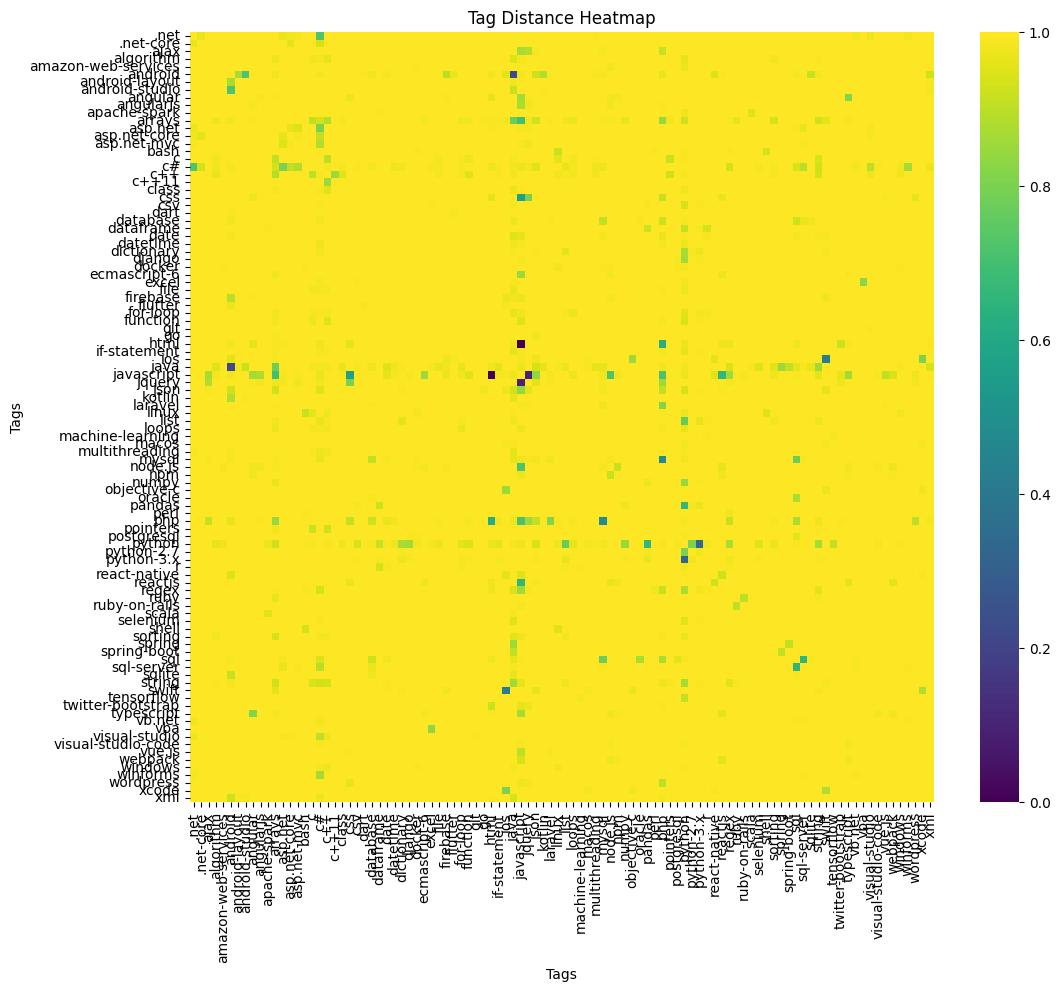

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 히트맵 플롯
plt.figure(figsize=(12, 10))
sns.heatmap(dist_mat, xticklabels=dist_mat.columns, yticklabels=dist_mat.columns, cmap='viridis', annot=False)
plt.title("Tag Distance Heatmap")
plt.xlabel("Tags")
plt.ylabel("Tags")
plt.show()

### 3. GPT comments

In [ ]:
import os
import openai  # OpenAI 라이브러리
from google.colab import userdata

# OpenAI API 키 환경 변수에서 가져오기
openai_api_key = userdata.get('OPENAI_API_KEY')


if openai_api_key is None:
    raise ValueError("OpenAI API key is not set. Please set it in your environment variables or .env file.")


# OpenAI API를 사용해 요약 생성
openai.api_key = openai_api_key


In [ ]:
#from openai import OpenAI
import openai  # OpenAI 라이브러리
from openai import OpenAI
openai_api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)
# OpenAI API 키 환경 변수에서 가져오기



# Convert the DataFrame to a string format for the prompt
table_str = df_clustered_tags.to_string(index=False)

# Define the prompt with role-based separation
messages = [
    {
        "role": "system",
        "content": (
            "You are a data analysis assistant skilled at evaluating clustering structures and suggesting improvements. "
            "Focus on assessing both inter-cluster distinctness and intra-cluster cohesion, and reassign tags for better clustering if necessary. "
            "Present all responses in a structured and clear format without deviating from the given instructions."
        )
    },
    {
        "role": "user",
        "content": (
            f"The following table shows tags grouped into {len(df_clustered_tags)} clusters:\n\n"
            f"{table_str}\n\n"
            "1. Please assess the appropriateness of the current clustering. Focus on evaluating inter-cluster similarity and intra-cluster diversity.\n"
            "2. Identify any tags that may be miscategorized and suggest a better fitting cluster if applicable.\n"
            "3. Finally, create an improved clustering based on this analysis and present it in a table format. "
            "Make sure to only include the tags and their suggested new cluster assignments.\n\n"
            "All responses should follow the below format:\n"
            "Analysis: [Provide a brief analysis on the current clustering structure]\n"
            "Recommendations: [List any tags that should be reassigned to other clusters]\n"
            "Improved Clustering Table:\n| Tag | New Cluster |\n| ---- | ----------- |\n| Tag1 | ClusterX |\n\n"
            "Limit the response to this format only."
        )
    }
]

# Call the OpenAI API to generate a response
response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        max_tokens=1000,
        temperature=0.5
)

# Print the response
#print(response.choices[0].message['content'])
response_text = response.choices[0].message.content



In [ ]:
import re

# Use regex to extract the table part from the response
# Add error handling for the case when the regex doesn't find a match
match = re.search(r"(\| Tag \| New Cluster \|[\s\S]+)", response_text)
if match:
    table_text = match.group(1).strip()

    # Process the extracted table text into rows
    rows = [row.split('|')[1:-1] for row in table_text.strip().split('\n') if row.strip()]
    rows = [[cell.strip() for cell in row] for row in rows]  # Clean up whitespace

    # Convert to a DataFrame
    df_improved = pd.DataFrame(rows, columns=["Tag", "New Cluster"])
else:
    print("No table found in the response. Please check the OpenAI response format.")
    df_improved = pd.DataFrame(columns=["Tag", "New Cluster"]) # Create an empty DataFrame

No table found in the response. Please check the OpenAI response format.


In [ ]:
print(response_text)

Analysis: The current clustering shows some degree of thematic grouping, but there are notable issues with inter-cluster similarity and intra-cluster diversity. For instance, clusters such as 0, 1, and 4 contain tags that are related but not necessarily distinct from tags in other clusters. Additionally, some clusters, like 7 and 12, have a mix of technologies and concepts that could be better organized.

Recommendations: 
- Move 'json' from Cluster 7 to Cluster 6 for better alignment with JavaScript technologies.
- Move 'amazon-web-services' from Cluster 7 to a new cluster for cloud services.
- Move 'docker' from Cluster 7 to a new cluster for containerization tools.
- Move 'pandas' from Cluster 3 to Cluster 8 due to its alignment with 'dataframe'.
- Move 'visual-studio-code' from Cluster 0 to Cluster 9 to group with other Microsoft-related technologies.
- Move 'date' from Cluster 8 to Cluster 4 to align with 'datetime'.

Improved Clustering Table:
| Tag                | New Cluster |

### Load GPR result

In [ ]:
new_tag_path = ('/content/drive/MyDrive/Colab Notebooks/Data/reCluster_byGPT.csv')
new_tag = pd.read_csv(new_tag_path)


In [ ]:
new_tag

,Cluster,Tags,Cluster Name,설명
0,0,"['sql', 'dataframe', 'sql-server', 'database',...",Databases,데이터베이스 관리 및 데이터 처리 관련 태그
1,1,"['css', 'html', 'javascript', 'jquery', 'json'...",Frontend,웹 개발의 프론트엔드 및 관련 프레임워크
2,2,"['visual-studio-code', 'visual-studio', 'andro...",Dev Tools,개발 도구 및 환경 관련 태그
3,3,"['bash', 'shell', 'linux', 'file', 'perl', 'po...",Systems,"시스템 프로그래밍, 스크립팅 및 자동화 관련 태그"
4,4,"['ios', 'react-native', 'objective-c', 'macos'...",iOS/macOS,iOS 및 macOS 애플리케이션 개발 관련 태그
5,5,"['tensorflow', 'machine-learning', 'python-3.x...",Data Science,"데이터 과학, 머신러닝 및 데이터 처리 관련 태그"
6,7,"['scala', 'kotlin', 'go', 'dart', 'flutter', '...",Mobile,모바일 및 크로스 플랫폼 개발 언어 및 프레임워크
7,8,"['php', 'laravel', 'amazon-web-services', 'wor...",Backend,백엔드 및 웹 프레임워크 관련 태그
8,9,"['algorithm', 'sorting', 'loops', 'function', ...",Algorithms,알고리즘 및 자료 구조 관련 태그


In [ ]:
# Check if 'unique_tags' and 'TAGS' values are the same.
# This code assumes 'unique_tags' is defined as in the provided code.
# It also assumes 'df_clustered_tags' DataFrame is created as in the provided code.

def compare_tags(unique_tags, df_clustered_tags):
    """Compares the unique tags with the tags in the clustered DataFrame.

    Args:
      unique_tags: A list of unique tags.
      df_clustered_tags: A DataFrame containing clustered tags.

    Returns:
      A boolean value indicating whether the tags are identical.
      A list of tags that are different
    """

    all_tags_from_new_tag = []
    for tags in new_tag['Tags']:
      try:
        # Attempt to convert the string representation of a list to an actual list
        tags_list = ast.literal_eval(tags)
        if isinstance(tags_list, list):  # Ensure it's actually a list
            all_tags_from_new_tag.extend(tags_list)
        else:
            print(f"Warning: Value '{tags}' in 'Tags' column is not a list.")
      except (SyntaxError, ValueError):
        print(f"Warning: Could not convert '{tags}' to a list.")



    # Check for set equality to compare unique tag sets
    if set(unique_tags) == set(all_tags_from_new_tag):
        return True, []
    else:
        diff = list(set(unique_tags) - set(all_tags_from_new_tag))
        diff2 = list(set(all_tags_from_new_tag) - set(unique_tags))
        return False, diff+diff2



In [ ]:

are_tags_same, different_tags = compare_tags(unique_tags, new_tag)

if are_tags_same:
    print("The 'unique_tags' and 'TAGS' values are the same.")
else:
    print("The 'unique_tags' and 'TAGS' values are different.")
    print(f"Different tags: {different_tags}")

The 'unique_tags' and 'TAGS' values are the same.


In [ ]:
attributes = list(new_tag['Cluster Name'].values)

In [ ]:
new_tag

,Cluster,Tags,Cluster Name,설명
0,0,"['sql', 'dataframe', 'sql-server', 'database',...",Databases,데이터베이스 관리 및 데이터 처리 관련 태그
1,1,"['css', 'html', 'javascript', 'jquery', 'json'...",Frontend,웹 개발의 프론트엔드 및 관련 프레임워크
2,2,"['visual-studio-code', 'visual-studio', 'andro...",Dev Tools,개발 도구 및 환경 관련 태그
3,3,"['bash', 'shell', 'linux', 'file', 'perl', 'po...",Systems,"시스템 프로그래밍, 스크립팅 및 자동화 관련 태그"
4,4,"['ios', 'react-native', 'objective-c', 'macos'...",iOS/macOS,iOS 및 macOS 애플리케이션 개발 관련 태그
5,5,"['tensorflow', 'machine-learning', 'python-3.x...",Data Science,"데이터 과학, 머신러닝 및 데이터 처리 관련 태그"
6,7,"['scala', 'kotlin', 'go', 'dart', 'flutter', '...",Mobile,모바일 및 크로스 플랫폼 개발 언어 및 프레임워크
7,8,"['php', 'laravel', 'amazon-web-services', 'wor...",Backend,백엔드 및 웹 프레임워크 관련 태그
8,9,"['algorithm', 'sorting', 'loops', 'function', ...",Algorithms,알고리즘 및 자료 구조 관련 태그


In [ ]:
# prompt: new_tag의 Tags를 list 형태 없이 string으로 바꾸기 [] 도 제거하기

new_tag['Tags_new'] = new_tag['Tags'].astype(str).str.replace(r'[\[\]\']', '', regex=True)

In [ ]:
new_tag

,Cluster,Tags,Cluster Name,설명,Tags_new
0,0,"['sql', 'dataframe', 'sql-server', 'database',...",Databases,데이터베이스 관리 및 데이터 처리 관련 태그,"sql, dataframe, sql-server, database, firebase..."
1,1,"['css', 'html', 'javascript', 'jquery', 'json'...",Frontend,웹 개발의 프론트엔드 및 관련 프레임워크,"css, html, javascript, jquery, json, angularjs..."
2,2,"['visual-studio-code', 'visual-studio', 'andro...",Dev Tools,개발 도구 및 환경 관련 태그,"visual-studio-code, visual-studio, android-stu..."
3,3,"['bash', 'shell', 'linux', 'file', 'perl', 'po...",Systems,"시스템 프로그래밍, 스크립팅 및 자동화 관련 태그","bash, shell, linux, file, perl, pointers, c, d..."
4,4,"['ios', 'react-native', 'objective-c', 'macos'...",iOS/macOS,iOS 및 macOS 애플리케이션 개발 관련 태그,"ios, react-native, objective-c, macos, swift"
5,5,"['tensorflow', 'machine-learning', 'python-3.x...",Data Science,"데이터 과학, 머신러닝 및 데이터 처리 관련 태그","tensorflow, machine-learning, python-3.x, pand..."
6,7,"['scala', 'kotlin', 'go', 'dart', 'flutter', '...",Mobile,모바일 및 크로스 플랫폼 개발 언어 및 프레임워크,"scala, kotlin, go, dart, flutter, node.js, npm..."
7,8,"['php', 'laravel', 'amazon-web-services', 'wor...",Backend,백엔드 및 웹 프레임워크 관련 태그,"php, laravel, amazon-web-services, wordpress, ..."
8,9,"['algorithm', 'sorting', 'loops', 'function', ...",Algorithms,알고리즘 및 자료 구조 관련 태그,"algorithm, sorting, loops, function, for-loop,..."


In [ ]:
# 태그별 클러스터 매핑을 생성
# "TAGS" 열을 각각의 태그로 분리하고, 해당 클러스터 이름으로 매핑하는 사전을 생성합니다.
tag_to_cluster_map = {}

for idx, row in new_tag.iterrows():
    tags = row['Tags_new'].split(',')  # TAGS 필드를 태그 리스트로 변환
    #tags = row['Tags_new']
    cluster_name = row['Cluster Name']  # 클러스터 이름
    for tag in tags:
        #print(tags = re.findall(r"'(.*?)'", text))
        tag_to_cluster_map[tag.strip()] = cluster_name


In [ ]:
tag_to_cluster_map

{'sql': 'Databases',
 'dataframe': 'Data Science',
 'sql-server': 'Databases',
 'database': 'Databases',
 'firebase': 'Databases',
 'postgresql': 'Databases',
 'mysql': 'Databases',
 'sqlite': 'Databases',
 'oracle': 'Databases',
 'css': 'Frontend',
 'html': 'Frontend',
 'javascript': 'Frontend',
 'jquery': 'Frontend',
 'json': 'Frontend',
 'angularjs': 'Frontend',
 'angular': 'Frontend',
 'twitter-bootstrap': 'Frontend',
 'reactjs': 'Frontend',
 'vue.js': 'Frontend',
 'typescript': 'Frontend',
 'ecmascript-6': 'Frontend',
 'webpack': 'Frontend',
 'ajax': 'Frontend',
 'visual-studio-code': 'Dev Tools',
 'visual-studio': 'Dev Tools',
 'android-studio': 'Dev Tools',
 'xcode': 'Dev Tools',
 'docker': 'Dev Tools',
 'git': 'Dev Tools',
 'windows': 'Dev Tools',
 'vb.net': 'Dev Tools',
 'c#': 'Dev Tools',
 'bash': 'Systems',
 'shell': 'Systems',
 'linux': 'Systems',
 'file': 'Systems',
 'perl': 'Systems',
 'pointers': 'Systems',
 'c': 'Systems',
 'date': 'Systems',
 'datetime': 'Systems',
 'w

In [ ]:
len(tag_to_cluster_map)

100

In [ ]:
tag_to_cluster_map

{"['sql'": 'Databases',
 "'dataframe'": 'Data Science',
 "'sql-server'": 'Databases',
 "'database'": 'Databases',
 "'firebase'": 'Databases',
 "'postgresql'": 'Databases',
 "'mysql'": 'Databases',
 "'sqlite'": 'Databases',
 "'oracle']": 'Databases',
 "['css'": 'Frontend',
 "'html'": 'Frontend',
 "'javascript'": 'Frontend',
 "'jquery'": 'Frontend',
 "'json'": 'Frontend',
 "'angularjs'": 'Frontend',
 "'angular'": 'Frontend',
 "'twitter-bootstrap'": 'Frontend',
 "'reactjs'": 'Frontend',
 "'vue.js'": 'Frontend',
 "'typescript'": 'Frontend',
 "'ecmascript-6'": 'Frontend',
 "'webpack'": 'Frontend',
 "'ajax']": 'Frontend',
 "['visual-studio-code'": 'Dev Tools',
 "'visual-studio'": 'Dev Tools',
 "'android-studio'": 'Dev Tools',
 "'xcode'": 'Dev Tools',
 "'docker'": 'Dev Tools',
 "'git'": 'Dev Tools',
 "'windows'": 'Dev Tools',
 "'vb.net'": 'Dev Tools',
 "'c#']": 'Dev Tools',
 "['bash'": 'Systems',
 "'shell'": 'Systems',
 "'linux'": 'Systems',
 "'file'": 'Systems',
 "'perl'": 'Systems',
 "'poin

In [ ]:
# 태그 필터 데이터를 클러스터 이름으로 변환하는 함수
def convert_tags_to_cluster(tags):
    return list({tag_to_cluster_map.get(tag, 'Unknown') for tag in tags})

# Tags_new 열 생성
#df['Tags_new'] = df['Tags_filtered'].apply(convert_tags_to_cluster)

df_train['Tags_new'] = df_train['Tags_list'].apply(convert_tags_to_cluster)

In [ ]:
df_train

,Title,Body,Tags_filtered,Tags_list,Tags_new
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,['java'],[java],[Algorithms]
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,['java'],[java],[Algorithms]
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,"['javascript', 'react-native']","[javascript, react-native]","[iOS/macOS, Frontend]"
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",['swift'],[swift],[iOS/macOS]
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,['android'],[android],[Systems]
...,...,...,...,...,...
40719,"Weird question, but how do I make a python scr...","<p>Before you get confused, I am going to comp...","['python', 'python-3.x']","[python, python-3.x]",[Data Science]
40720,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,"['c#', 'asp.net', 'sql-server']","[c#, asp.net, sql-server]","[Databases, Dev Tools, Backend]"
40721,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,['python'],[python],[Data Science]
40722,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...","['ios', 'swift']","[ios, swift]",[iOS/macOS]


In [ ]:


# df_train['Tags_new']에서 'Unknown' 값의 개수를 확인
unknown_count = df_train['Tags_new'].apply(lambda x: 'Unknown' in x).sum()
print(f"Unknown 값의 개수: {unknown_count}")

# 'Unknown' 값이 있는 행을 확인
unknown_rows = df_train[df_train['Tags_new'].apply(lambda x: 'Unknown' in x)]
print(unknown_rows[['Tags_list', 'Tags_new']].head(20))  # 또는 원하는 개수만큼 출력



Unknown 값의 개수: 0
Empty DataFrame
Columns: [Tags_list, Tags_new]
Index: []


### Count each tag

In [ ]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer
def unpivot_tags(df):
  mlb = MultiLabelBinarizer()
  tags_dummies = pd.DataFrame(mlb.fit_transform(df['Tags_new']), columns=mlb.classes_, index=df.index)
  df_unpivoted = pd.concat([df, tags_dummies], axis=1)
  return df_unpivoted


In [ ]:
unpivot_train = unpivot_tags(df_train)


In [ ]:
unpivot_train

,Title,Body,Tags_filtered,Tags_list,Tags_new,Algorithms,Backend,Data Science,Databases,Dev Tools,Frontend,Mobile,Systems,iOS/macOS
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,['java'],[java],[Algorithms],1,0,0,0,0,0,0,0,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,['java'],[java],[Algorithms],1,0,0,0,0,0,0,0,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,"['javascript', 'react-native']","[javascript, react-native]","[iOS/macOS, Frontend]",0,0,0,0,0,1,0,0,1
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",['swift'],[swift],[iOS/macOS],0,0,0,0,0,0,0,0,1
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,['android'],[android],[Systems],0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40719,"Weird question, but how do I make a python scr...","<p>Before you get confused, I am going to comp...","['python', 'python-3.x']","[python, python-3.x]",[Data Science],0,0,1,0,0,0,0,0,0
40720,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,"['c#', 'asp.net', 'sql-server']","[c#, asp.net, sql-server]","[Databases, Dev Tools, Backend]",0,1,0,1,1,0,0,0,0
40721,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,['python'],[python],[Data Science],0,0,1,0,0,0,0,0,0
40722,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...","['ios', 'swift']","[ios, swift]",[iOS/macOS],0,0,0,0,0,0,0,0,1


In [ ]:
val = list(unpivot_train.columns[5:])

In [ ]:
new_tag['Cluster Name']

,Cluster Name
0,Databases
1,Frontend
2,Dev Tools
3,Systems
4,iOS/macOS
5,Data Science
6,Mobile
7,Backend
8,Algorithms


In [ ]:
import matplotlib.pyplot as plt
def dist_plot(df, val):
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
  # If you have only one subplot, you can directly use axes instead of axes[0]
  df[val].sum().plot(kind='bar', ax=axes, title='Tag Distribution')
  plt.show()


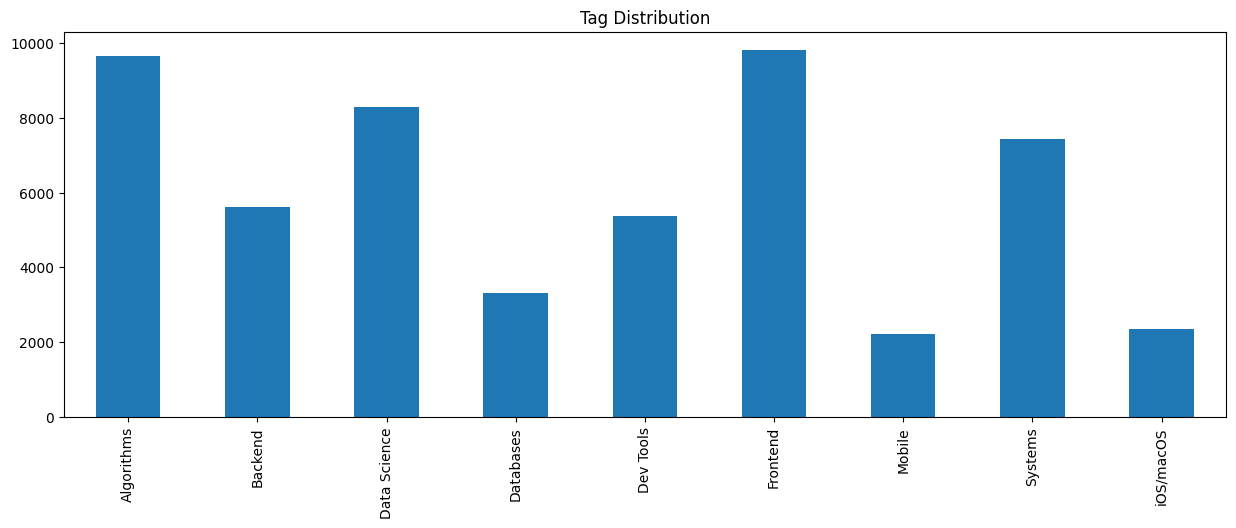

In [ ]:
dist_plot(unpivot_train, val)

In [ ]:
unpivot_train[val].sum()

,0
Algorithms,9655
Backend,5628
Data Science,8302
Databases,3311
Dev Tools,5390
Frontend,9820
Mobile,2215
Systems,7431
iOS/macOS,2353


In [ ]:
import pandas as pd
import numpy as np

def sample_by_category(data, target_counts):
    """
    각 카테고리에서 지정된 샘플 수에 따라 무작위로 샘플을 추출합니다.
    지정된 샘플 수보다 실제 샘플 수가 많으면 비복원 추출, 부족하면 복원 추출을 합니다.

    Parameters:
    - data (pd.DataFrame): 전체 데이터셋
    - category_column (str): 카테고리 컬럼명
    - target_counts (dict): 카테고리별로 추출하고자 하는 샘플 수 (예: {category: count})

    Returns:
    - pd.DataFrame: 각 카테고리에서 지정된 수의 샘플을 포함한 데이터셋
    """
    sampled_data = []

    for category, target_count in target_counts.items():
        # 해당 카테고리의 데이터 필터링
        category_data = data[data[category] == 1]
        actual_count = len(category_data)

        # 비복원/복원 추출 결정 및 샘플링
        if actual_count >= target_count:
            sampled_category_data = category_data.sample(n=target_count, replace=False, random_state=42)
        else:
            sampled_category_data = category_data.sample(n=target_count, replace=True, random_state=42)

        sampled_data.append(sampled_category_data)

    # 결과 합치기
    return pd.concat(sampled_data ) #, ignore_index=True)



In [ ]:
# prompt: target_counts 만드는 함수를 만들어줘. 만약 input 으로 sample 수를 20000을 넣는 다면 현재 tag의 수로 나누어서 2000개를 만들수 있게 해야해. {tag명칭: 1000, ...} , 정확하게 20000이 되도록 해줘.

def create_target_counts(sample_size, tag_counts):
    """
    샘플 수와 태그별 개수를 기반으로 target_counts를 생성합니다.

    Args:
        sample_size: 전체 샘플 수.
        tag_counts: 태그별 개수 (Series).

    Returns:
        태그별 target 개수 (dict).
    """
    total_tags = len(tag_counts)
    target_counts_per_tag = sample_size // total_tags
    remainder = sample_size % total_tags

    target_counts = {}
    for tag in tag_counts:
        target_counts[tag] = target_counts_per_tag

    # 나머지 샘플을 태그에 추가 (순서대로 추가)
    for i in range(remainder):
        tag = tag_counts[i]
        target_counts[tag] += 1

    return target_counts


In [ ]:
target_counts = create_target_counts(20000,val)

In [ ]:
target_counts

{'Algorithms': 2223,
 'Backend': 2223,
 'Data Science': 2222,
 'Databases': 2222,
 'Dev Tools': 2222,
 'Frontend': 2222,
 'Mobile': 2222,
 'Systems': 2222,
 'iOS/macOS': 2222}

In [ ]:
even_samples = sample_by_category(unpivot_train, target_counts)

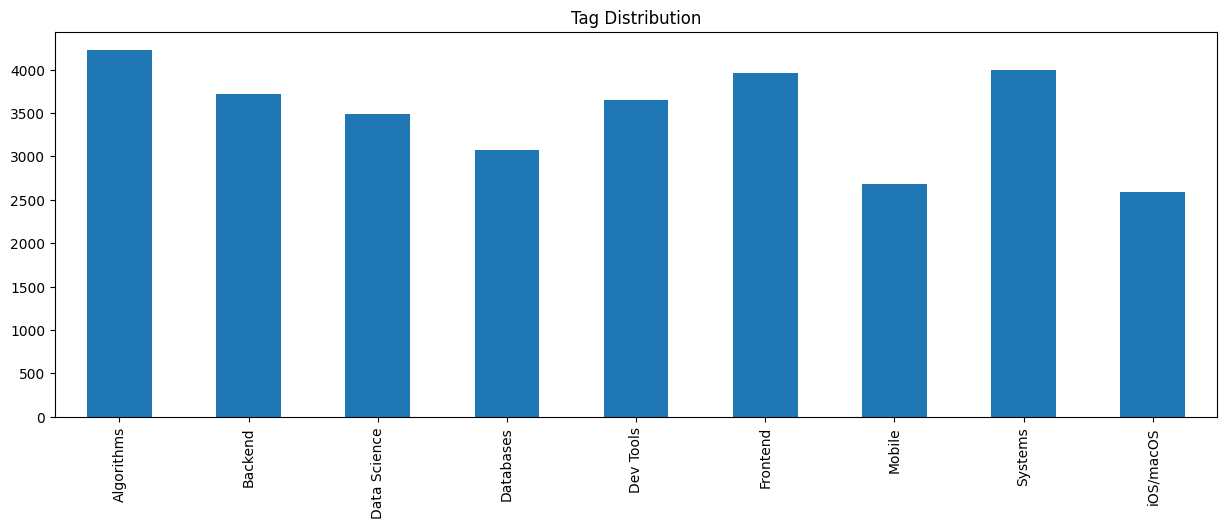

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
# If you have only one subplot, you can directly use axes instead of axes[0]
even_samples[val].sum().plot(kind='bar', ax=axes, title='Tag Distribution')
plt.show()


In [ ]:
even_samples

,Title,Body,Tags_filtered,Tags_list,Tags_new,Algorithms,Backend,Data Science,Databases,Dev Tools,Frontend,Mobile,Systems,iOS/macOS
35392,Why threads are needed in my given assignment ...,<p><strong>I'm not asking to do my assignment....,"['java', 'multithreading']","[java, multithreading]",[Algorithms],1,0,0,0,0,0,0,0,0
23853,pointer from one class to anotehr,"Hello I want to point ""seller"" to ""name""\r\nbu...","['c++', 'class', 'pointers']","[c++, class, pointers]","[Systems, Algorithms]",1,0,0,0,0,0,0,1,0
3182,How can I remove every 6th comma in a CSV file...,<p>For a current project I need to remove the ...,"['python', 'regex', 'csv', 'python-3.x']","[python, regex, csv, python-3.x]","[Algorithms, Data Science]",1,0,1,0,0,0,0,0,0
33542,Single Linked List in reverse order Java,<p>How to write a code for printing Single lin...,['java'],[java],[Algorithms],1,0,0,0,0,0,0,0,0
40167,Java enum for loop,<p>I have to count how many time enum START wa...,['java'],[java],[Algorithms],1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29003,expression pattern of type 'Int' cannot match ...,<p>I am getting below error during Objective-C...,"['ios', 'swift']","[ios, swift]",[iOS/macOS],0,0,0,0,0,0,0,0,1
14205,NSNotificationCenter Swift 3.0 on keyboard sho...,<p>I am trying to run a function when the keyb...,"['ios', 'swift']","[ios, swift]",[iOS/macOS],0,0,0,0,0,0,0,0,1
20066,React Native: require() with Dynamic String?,<p>I have read several posts about issues that...,"['javascript', 'reactjs', 'react-native', 'ecm...","[javascript, reactjs, react-native, ecmascript-6]","[iOS/macOS, Frontend]",0,0,0,0,0,1,0,0,1
21894,how can i remove the extra bottom tab bar crea...,i'm using xcode and swift to create an iOS app...,"['ios', 'swift']","[ios, swift]",[iOS/macOS],0,0,0,0,0,0,0,0,1


In [ ]:

# even_samples에 포함되지 않은 데이터 추출
remaining_samples = unpivot_train[~unpivot_train.index.isin(even_samples.index)]

# remaining_samples에서 6500개 랜덤 샘플링
random_6500 = remaining_samples.sample(n=6500, random_state=42)

# 나머지 데이터 추출
other_samples = remaining_samples[~remaining_samples.index.isin(random_6500.index)]

# 그 나머지에서 3000개 랜덤 샘플링
random_3000 = other_samples.sample(n=3000, random_state=42)

# 그 나머지 데이터 추출
the_other_samples = other_samples[~other_samples.index.isin(random_3000.index)]




#random_6500 = random_6500.reset_index(drop= True)

In [ ]:
print(len(even_samples))
print(len(random_6500))
print(len(random_3000))
print(len(the_other_samples))


20000
6500
3000
13965


In [ ]:
def dist_plot(df, val):
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
  # If you have only one subplot, you can directly use axes instead of axes[0]
  df[val].sum().plot(kind='bar', ax=axes, title='Tag Distribution')
  plt.show()

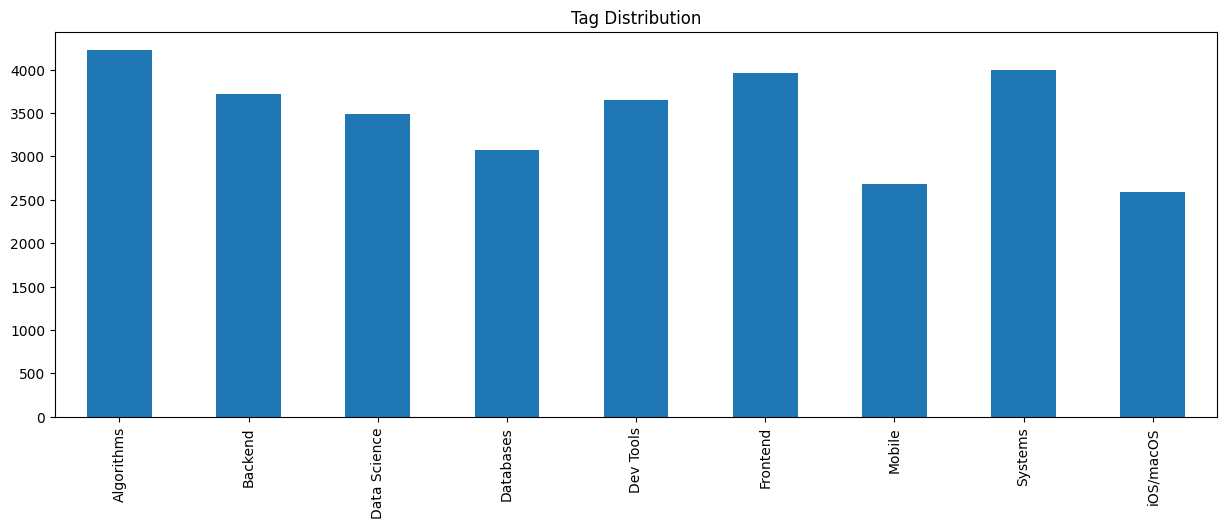

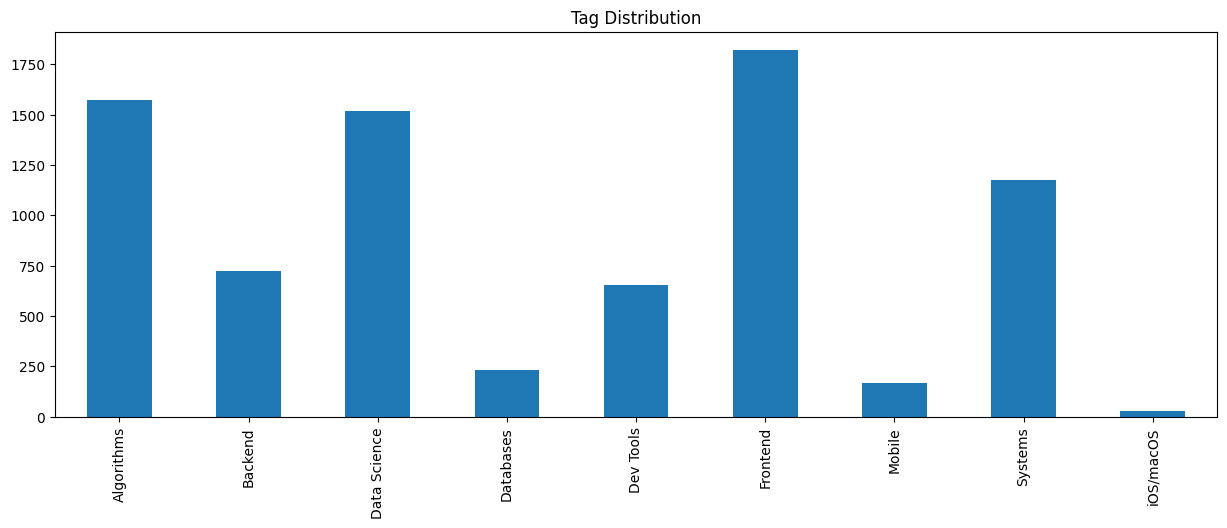

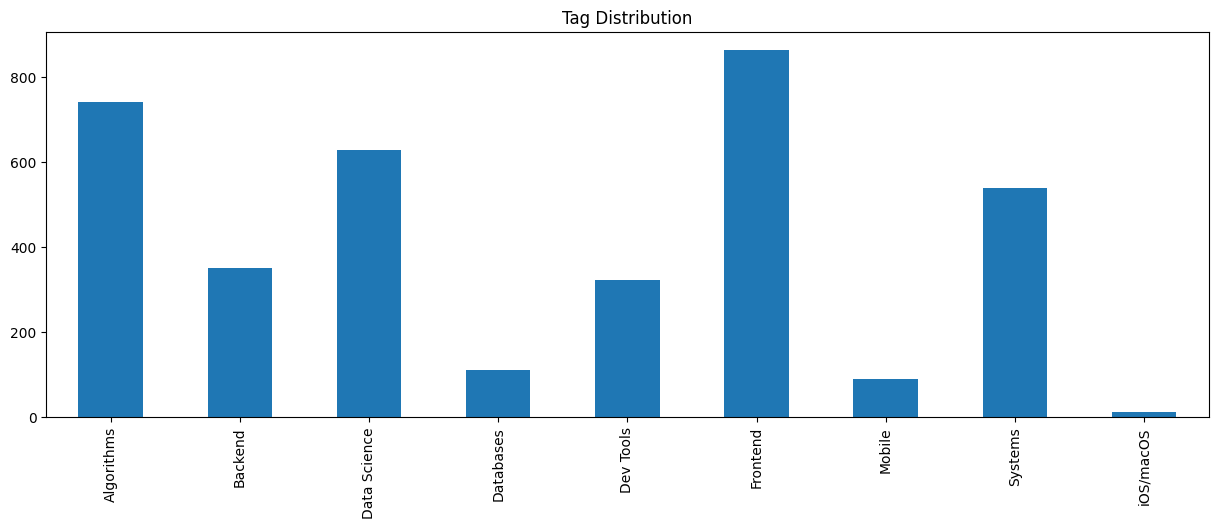

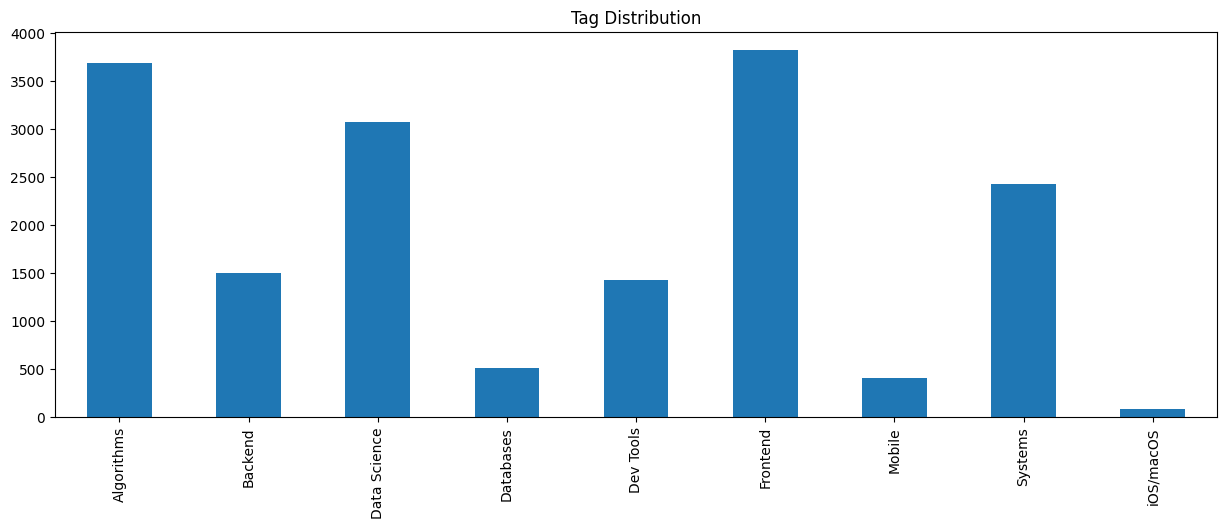

In [ ]:
dist_plot(even_samples, val)
dist_plot(random_6500, val)
dist_plot(random_3000, val)
dist_plot(the_other_samples, val)

In [ ]:
even_samples.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/rev_tag_training_samples_1.csv', index=False)
random_6500.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/rev_tag_validation_samples_1.csv', index=False)
random_3000.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/rev_tag_test_samples_1.csv', index=False)
the_other_samples.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/otherclassifier_samples_1.csv', index=False)

In [ ]:
other_samples

,Title,Body,Tags_filtered,Tags_list,Tags_new,Algorithms,Backend,Data Science,Databases,Dev Tools,Frontend,Mobile,Systems,iOS/macOS
0,Support v7 MenuPopupHelper is now hidden and r...,<p>Recently i've been getting a lint error on ...,['android'],[android],[Systems],0,0,0,0,0,0,0,1,0
1,If condition inside of map() React,<p>I have a <code>map()</code>function that ne...,['reactjs'],[reactjs],[Frontend],0,0,0,0,0,1,0,0,0
2,Why are non-placement `new` and `delete` built...,"<p>Why were the non-placement <a href=""http://...",['c++'],[c++],[Algorithms],1,0,0,0,0,0,0,0,0
3,How to add class all row,"In given example, I can select/deselect each r...","['javascript', 'jquery']","[javascript, jquery]",[Frontend],0,0,0,0,0,1,0,0,0
4,How do people handle scroll restoration with r...,<p>I'm experiencing some problems with scroll ...,['reactjs'],[reactjs],[Frontend],0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20719,"Weird question, but how do I make a python scr...","<p>Before you get confused, I am going to comp...","['python', 'python-3.x']","[python, python-3.x]",[Data Science],0,0,1,0,0,0,0,0,0
20720,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,"['c#', 'asp.net', 'sql-server']","[c#, asp.net, sql-server]","[Backend, Dev Tools, Databases]",0,1,0,1,1,0,0,0,0
20721,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,['python'],[python],[Data Science],0,0,1,0,0,0,0,0,0
20722,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...","['ios', 'swift']","[ios, swift]",[iOS/macOS],0,0,0,0,0,0,0,0,1


In [ ]:

# Check if 'unique_tags' and 'Tags_new' values are the same.
def compare_tags_new(unique_tags, df_train):
    """Compares the unique tags with the tags in the clustered DataFrame.

    Args:
      unique_tags: A list of unique tags.
      df_train: A DataFrame containing clustered tags.

    Returns:
      A boolean value indicating whether the tags are identical.
      A list of tags that are different
    """
    all_tags_from_df_train = []
    for tags_list in df_train['Tags_new']:
      all_tags_from_df_train.extend(tags_list)

    # Check for set equality to compare unique tag sets
    if set(unique_tags) == set(all_tags_from_df_train):
        return True, []
    else:
        diff = list(set(unique_tags) - set(all_tags_from_df_train))
        diff2 = list(set(all_tags_from_df_train) - set(unique_tags))
        return False, diff + diff2

are_tags_same_new, different_tags_new = compare_tags_new(unique_tags, df_train)

if are_tags_same_new:
    print("The 'unique_tags' and 'Tags_new' values are the same.")
else:
    print("The 'unique_tags' and 'Tags_new' values are different.")
    print(f"Different tags: {different_tags_new}")

### Even_valid_samples

In [ ]:
df_test['Tags_new'] = df_test['Tags_list'].apply(convert_tags_to_cluster)
unpivot_test = unpivot_tags(df_test)


KeyError: 'Tags_list'

In [ ]:
df_test


,Title,Body,Tags_filtered
0,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,"['sql', 'sql-server']"
1,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,"['php', 'mysql', 'sql']"
2,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,"['python', 'pandas']"
3,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",['sql-server']
4,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,['php']
...,...,...,...
13630,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...","['html', 'css']"
13631,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,['c++']
13632,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,['django']
13633,PHP - getting the content of php page,<p>I have a controller inside which a server i...,"['javascript', 'php', 'html']"
